<a href="https://colab.research.google.com/github/sakshigorkhali/Scholar_recommender/blob/master/1_Sakshi_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Recommender System for Scholar Papers**
DSC 478 : Final Project

Creator: Sakshi Gorkhali
###---------------------------------------------------------------------------------------------------

**Project Description:**

Our aim is to build a content-based recommender system that helps researchers quickly find relevant PubMed articles for a given GEO dataset(genome dataset) by identifying and recommending similar literature.

We have two dataset: Pubmed data that contains data about pubmed articles including pubmed id (pmid) and Geo dataset which is a meta data of geo expression.

As our recommender system is completely content based we aim to explore different vectorization techniques to evaluate their performance in recommending relevant papers and later combine two best performing to buil a hybrid recommender system

For evaluation: Our two dataset both have PMIDs column which links the geo and pubmed data together. (pmid is unique identiciation article number so when researchers upload their geo metadata they also submit a pind that they wrote which related to research paper that was written based on the data. so during eval we check where this matching pmid is recommended in the top 10 or not to evaluate performance.


### -------------------------------------------------------------------------------------------

This is the first notebook that **contains**:
- Data Cleaning and exploration process
- Vectorization techniques:
  - TFIDF
  - Weighted TFIDF
  - Word2Vec
  - BioWord2Vec

### -------------------------------------------------------------------
**Requirements**:
- pandas== 2.2.2
- numpy== 1.26.4
- nltk== 3.9.1
- spacy== 3.8.7
- matplotlib== 3.10.0
- seaborn== 0.13.2
- scikit-learn== 1.6.1
- scipy== 1.13.1
- gensim== 4.3.3
- wordcloud== 1.9.4

- Bio-word2vec pre trained embedding (BioWordVec_PubMed_MIMICIII_d200.vec.bin) file included among the files. can be found in !wget https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin  

Dataset used:
geo_final_5000.csvpubmed_final_5000.csv
### -----------------------------------------------------------------------------------------------------------------------------------------------
**Next :** Please refer to other notebooks for different vectorization techniques


In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from scipy.sparse import hstack
!pip install --upgrade gensim
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from wordcloud import WordCloud
from collections import Counter
import random


In [ ]:
# !python -m spacy download en_core_web_sm
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim import corpora, models

In [ ]:
# For removing stop words and converting to word tokens
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


###**Reading our datasets**

In [ ]:
geo_data = pd.read_csv('geo_final_5000.csv')
pubmed_data = pd.read_csv('pubmed_final_5000.csv')

In [ ]:
geo_data.head()

,Series_ID,Title,Summary,Publication_Date,Authors,PMIDs
0,GSE294364,antibiotics driven gut microbiome perturbation...,the gut microbiome plays crucial role modulati...,2025/06/01,24676,"[IntegerElement(40252648, attributes={})]"
1,GSE287057,gene knockout screen identify genes involved h...,during cortical development neural stemprecurs...,2025/05/31,16791,"[IntegerElement(40377017, attributes={})]"
2,GSE284317,gene expression profile embryonic stem cellder...,human embryonic stem cells escs were different...,2025/05/31,24676,"[IntegerElement(40447714, attributes={})]"
3,GSE284316,gene expression profile embryonic stem cellder...,human embryonic stem cells escs were different...,2025/05/31,18573,"[IntegerElement(40447714, attributes={})]"
4,GSE298577,transcriptional responses prevnar13 vaccinatio...,thus dataset includes transcriptional profilin...,2025/05/30,13158,"[IntegerElement(39747435, attributes={})]"


In [ ]:
geo_data.shape

(3511, 6)

In [ ]:
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Series_ID         3511 non-null   object
 1   Title             3511 non-null   object
 2   Summary           3511 non-null   object
 3   Publication_Date  3511 non-null   object
 4   Authors           3508 non-null   object
 5   PMIDs             3511 non-null   object
dtypes: object(6)
memory usage: 164.7+ KB


In [ ]:
geo_data.describe().T

,count,unique,top,freq
Series_ID,3511,3511,GSE294364,1
Title,3511,3393,glucocorticoid receptor suppresses gata6mediat...,7
Summary,3511,2595,this superseries composed the subseries listed...,194
Publication_Date,3511,193,2025/01/14,341
Authors,3508,349,24676,1454
PMIDs,3511,2184,"[IntegerElement(22955616, attributes={})]",326


#### Lets deal with the pmids and perform some cleaning to extract only the pmid numbers from the Pmid column of the geo data

In [ ]:
def extract_pmids(pmid_str):
    return [int(num) for num in re.findall(r'\d+', pmid_str)]

In [ ]:
geo_data['PMIDs_list'] = geo_data['PMIDs'].apply(extract_pmids)
geo_data.drop(columns = ['PMIDs'], inplace = True)
# geo_data.rename(columns={'PMIDs_list': 'PMIDs'}, inplace=True)


In [ ]:
# Extracting all the pmids
all_pmids = [pmid for sublist in geo_data['PMIDs_list'] for pmid in sublist]
geo_pmids = set(all_pmids)
pubmed_pmids = set(map(int, pubmed_data['PMID']))
print('Unique geo pmid: ', len(geo_pmids))
print('Unique pubmed pmid: ', len(pubmed_pmids))

Unique geo pmid:  2211
Unique pubmed pmid:  5000


In [ ]:
# Checking to see how many pmid match both our pubmed and geo data has:
geo_explore = geo_data.copy()
def has_matching_pmid(pmid_list):
  '''Checks if there is matching pmid among our geo data and pubdmed data'''
  if isinstance(pmid_list, list):
    return any(pmid in pubmed_pmids for pmid in pmid_list)
  return False  # In case of NaNs or non-list entries

# Applying the function to each row
geo_explore['HasMatch'] = geo_explore['PMIDs_list'].apply(has_matching_pmid)

In [ ]:
print("Rows with at least one matching PMID:", geo_explore['HasMatch'].sum())
print('Total row of geo data:', geo_data.shape[0])

Rows with at least one matching PMID: 3511
Total row of geo data: 3511


In [ ]:
# Exploring and cleaning Pubmed data:
pubmed_data.head()

,PMID,Title,Abstract,Authors,Affiliations,MeSH_Terms,Publisher
0,40389645,transcriptomic profiling immune modulation ind...,the vitdpas study nct06104111 was designed med...,"Gospodarska E, Dastidar RG, Jaroslawska J, Ryb...",NaN,"Adult, Female, Humans, Male, Middle Aged, Youn...",Scientific reports
1,39850778,using integrative bioinformatics approaches an...,atrial fibrillation the most common tachyarrhy...,"Fu S, Feng Z, Li A, Ma Z, Zhang H, Zhao Z",NaN,NaN,International journal of cardiology. Heart & v...
2,39649166,dna methylation signature lifestylebased resil...,cognitive resilience contributes the variabili...,"Zhang W, Lukacsovich D, Young JI, Gomez L, Sch...",NaN,NaN,Research square
3,40093158,clinical progression clonal hematopoiesis dete...,clonal hematopoiesis characterized expanding b...,"Latorre-Crespo E, Robertson NA, Kosebent EG, M...",NaN,NaN,bioRxiv : the preprint server for biology
4,40178292,rnf112 facilitates ubiquitinmediated degradati...,the ubiquitin ligase rnf112 significantly down...,"Xiong K, Chen S, Xu H, Tu S, Weng H, Wang Y, L...",NaN,"Urinary Bladder Neoplasms, Cell Proliferation,...","Advanced science (Weinheim, Baden-Wurttemberg,..."


In [ ]:
pubmed_data.info()
pubmed_data['PMID'] = pubmed_data['PMID'].astype(str)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PMID          5000 non-null   int64  
 1   Title         5000 non-null   object 
 2   Abstract      4963 non-null   object 
 3   Authors       4991 non-null   object 
 4   Affiliations  0 non-null      float64
 5   MeSH_Terms    4367 non-null   object 
 6   Publisher     5000 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 273.6+ KB


In [ ]:
pubmed_data.drop(columns = ['Affiliations'], inplace = True)
pubmed_data.iloc[6:10]

,PMID,Title,Abstract,Authors,MeSH_Terms,Publisher
6,39897955,serumderived small extracellular vesicles biom...,endometriosis can cause infertility and evalua...,"Muraoka A, Yokoi A, Yoshida K, Kitagawa M, Mur...","Humans, Female, Endometriosis, Pregnancy, Extr...",Frontiers in endocrinology
7,40101298,targeting prame directly via ezh2 inhibition o...,retinoids have demonstrated efficacy preventat...,"Ramchatesingh B, Martinez Villarreal A, Lefran...","Enhancer of Zeste Homolog 2 Protein, Antigens,...",Molecular oncology
8,39702481,quickdash find unique genes and biological pro...,osteoarthritis disease impacting the synovial ...,"Lynskey SJ, Gill SD, McGee SL, Ziemann M, Page RS","Humans, Osteoarthritis, Case-Control Studies, ...",BMC research notes
9,39656918,the cterminal phdvc5hch tandem domain nsd2 com...,histone methyltransferase nsd2 mmset overexpre...,"Berardi A, Kaestner CL, Ghitti M, Quilici G, C...","Multiple Myeloma, Humans, Histone-Lysine N-Met...",Nucleic acids research


In [ ]:
pubmed_data.describe(include = 'all').T

,count,unique,top,freq
PMID,5000,5000,40389645,1
Title,5000,4990,infiltrating lipidrich macrophage subpopulatio...,2
Abstract,4963,4962,the human placenta the composite multiple cell...,2
Authors,4991,4984,Kato TA,2
MeSH_Terms,4367,4367,"Adult, Female, Humans, Male, Middle Aged, Youn...",1
Publisher,5000,1142,Scientific reports,245


### **Data Cleaning**
#### Removing stopwords and punctuations
##### Creating a function to remove punctuations and stop words:
- This removes unnecessary punctuation and stop words from our data and also removes periods(.) only if it is followed by a space or the end of the string.
- Makes all the letters in lowercase inorder to match except for the author column
- We are also removing standalone numbers.
--- For the author column preserves the capital letters and also the commas for now

In [ ]:
def clean_text(text, protected_symbols = {'/', '-', '+', ':'}, column_name = None):
     # Skipping non-string values like NaN so that it doesnt give error saying its float:
    if not isinstance(text, str):
        return text

    # --- For all other columns ---
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r'\.(?=\s|$)', '', text)  # Remove sentence - ending periods
    text = re.sub(r'(?<!\w)\d+(?!\w)', '', text) # Removes standalone numbers

    doc = nlp(text)
    final_tokens = [
        token.lemma_ for token in doc
        if not token.is_space
        and token.text not in stop_words and
        (not token.is_punct or token.text in protected_symbols)
    ]

    return ' '.join(final_tokens)


##### - Applying our function to necessary columns of geo_data:

In [ ]:
columns_to_clean = ['Title', 'Summary']

for col in columns_to_clean:
    geo_data[col] = geo_data[col].apply(lambda x: clean_text(x, column_name = col))

In [ ]:
geo_data.head(5)
geo_data.describe().T

,count,unique,top,freq
Series_ID,3511,3511,GSE294364,1
Title,3511,3391,glucocorticoid receptor suppresse gata6mediate...,7
Summary,3511,2594,superserie compose subserie list,194
Publication_Date,3511,193,2025/01/14,341
Authors,3508,349,24676,1454
PMIDs_list,3511,2184,[22955616],326


##### - Doing the same data cleaning with our pub med data:

In [ ]:
# Applying our function to our punmed_data:
columns_to_clean = ['Title', 'Abstract', 'MeSH_Terms']

for col in columns_to_clean:
    pubmed_data[col] = pubmed_data[col].apply(lambda x: clean_text(x, column_name = col))

In [ ]:
pubmed_data

,PMID,Title,Abstract,Authors,MeSH_Terms,Publisher
0,40389645,transcriptomic profiling immune modulation ind...,vitdpas study nct06104111 design medical exper...,"Gospodarska E, Dastidar RG, Jaroslawska J, Ryb...",adult female human male middle aged young adul...,Scientific reports
1,39850778,use integrative bioinformatics approach machin...,atrial fibrillation common tachyarrhythmia ser...,"Fu S, Feng Z, Li A, Ma Z, Zhang H, Zhao Z",NaN,International journal of cardiology. Heart & v...
2,39649166,dna methylation signature lifestylebased resil...,cognitive resilience contribute variability ri...,"Zhang W, Lukacsovich D, Young JI, Gomez L, Sch...",NaN,Research square
3,40093158,clinical progression clonal hematopoiesis dete...,clonal hematopoiesis characterize expand blood...,"Latorre-Crespo E, Robertson NA, Kosebent EG, M...",NaN,bioRxiv : the preprint server for biology
4,40178292,rnf112 facilitate ubiquitinmediated degradatio...,ubiquitin ligase rnf112 significantly downregu...,"Xiong K, Chen S, Xu H, Tu S, Weng H, Wang Y, L...",urinary bladder neoplasm cell proliferation hu...,"Advanced science (Weinheim, Baden-Wurttemberg,..."
...,...,...,...,...,...,...
4995,40438432,family function psychosocial burden caregiver ...,sickle cell disease scd chronic genetic disord...,"Abdulkadir M, Alabi Kola M, Oyeleke Oyeronke A...",human anemia sickle cell female nigeria male c...,Ethiopian journal of health sciences
4996,40405228,intersubject correlation predictor attention s...,metaanalysis examine challenge capture brain a...,"Liu Q, Lin Y, Zhang W",attention human brain neuroimage,BMC psychology
4997,40438111,tumorinfiltrate immune cell stateimplication v...,breast cancer present variety subtype due cell...,"Xu T, Zhang H, Yang BB, Qadir J, Yuan H, Ye T",human breast neoplasm tumor microenvironment f...,Frontiers in immunology
4998,40416965,delay diagnosis full triad autoimmune polyendo...,autoimmune polyendocrine syndrome type aps2 ra...,"Yao Z, Xu D, Hu X, Ge D, Xu X, Chen H",human female polyendocrinopathie autoimmune ag...,Frontiers in immunology


In [ ]:
def data_processing(geo_data, pubmed_data):
  # Joining the title and summary for geo_data, title, abstract and meshtermfor pubmed:
    geo_df = pd.DataFrame(geo_data[['Title', 'Summary']].fillna('').agg(' '.join, axis=1))
    pubmed_df = pd.DataFrame(pubmed_data[['Title', 'Abstract', 'MeSH_Terms']].fillna('').agg(' '.join, axis=1))
    entire_text = pd.concat([geo_df, pubmed_df])
    return geo_df, pubmed_df, entire_text.iloc[:, 0].astype(str).tolist()

In [ ]:
geo_df, pubmed_df, entire_text = data_processing(geo_data, pubmed_data)
pubmed_df

,0
0,transcriptomic profiling immune modulation ind...
1,use integrative bioinformatics approach machin...
2,dna methylation signature lifestylebased resil...
3,clinical progression clonal hematopoiesis dete...
4,rnf112 facilitate ubiquitinmediated degradatio...
...,...
4995,family function psychosocial burden caregiver ...
4996,intersubject correlation predictor attention s...
4997,tumorinfiltrate immune cell stateimplication v...
4998,delay diagnosis full triad autoimmune polyendo...


In [ ]:
entire_text[0:2]

['antibiotic drive gut microbiome perturbation alter immune response rabie vaccine gut microbiome play crucial role modulate human immunity previously find antibioticinduce microbiome perturbation affect influenza vaccine response depend preexist immunity level however impact primary response remain unclear employ system biology approach analyze impact antibiotic administration primary secondary immune response rabie vaccine humans antibiotic administration disrupt microbiome reduce gut bacterial load cause longlaste reduction commensal diversity alteration associate reduce rabiesspecific humoral response multiomic profiling reveal antibiotic administration induce enhance proinflammatory signature early vaccination shift balance vaccinespecific thelper 1th1 tfollicularhelper response towards th1 phenotype profound alteration metabolite particularly secondary bile acid blood integrate multiomics dataset generate multiscale multiresponse network reveal key regulatory node include microbi

###Function to explore the top content of our pub and geo data


In [ ]:
# Data exploration
def analyze_frequent_terms(text_data, top_n = 10):
    """Analyze most frequent terms for domain relevance"""

    # Combine all text and split into words
    all_text = ' '.join(text_data.iloc[:, 0].astype(str))
    words = all_text.split()

    # Count frequencies
    word_freq = Counter(words)
    top_words = word_freq.most_common(top_n)

    # Display results
    print(f"TOP {top_n} MOST FREQUENT TERMS:")
    for word, freq in top_words:
        print(f"{word:15} : {freq:4d}")

    return word_freq, top_words

# Word cloud visualization
def create_wordclouds(geo_text, pubmed_text):
    """Create word clouds for visual inspection"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # GEO word cloud
    geo_combined = ' '.join(geo_text.iloc[:, 0].astype(str))
    geo_wordcloud = WordCloud(width=400, height=300,
                             background_color='white',
                             max_words=100,
                             colormap='Blues').generate(geo_combined)

    axes[0].imshow(geo_wordcloud, interpolation='bilinear')
    axes[0].set_title('GEO Dataset Terms', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # PubMed word cloud
    pubmed_combined = ' '.join(pubmed_text.iloc[:, 0].astype(str))
    pubmed_wordcloud = WordCloud(width=400, height=300,
                                background_color='white',
                                max_words=100,
                                colormap='Reds').generate(pubmed_combined)

    axes[1].imshow(pubmed_wordcloud, interpolation='bilinear')
    axes[1].set_title('PubMed Articles Terms', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig("wordclouds_geo_pubmed.png", dpi=300)
    plt.show()

### Frequent terms of geo and pub


2. FREQUENT TERMS ANALYSIS:

GEO Dataset:
TOP 10 MOST FREQUENT TERMS:
cell            : 8814
gene            : 3492
expression      : 2686
cancer          : 2310
human           : 2230
patient         : 1835
study           : 1771
analysis        : 1619
use             : 1610
identify        : 1583

PubMed Dataset:
TOP 10 MOST FREQUENT TERMS:
cell            : 10903
human           : 6720
study           : 5307
-               : 3817
patient         : 3657
gene            : 3537
cancer          : 3108
protein         : 3021
expression      : 2988
use             : 2967


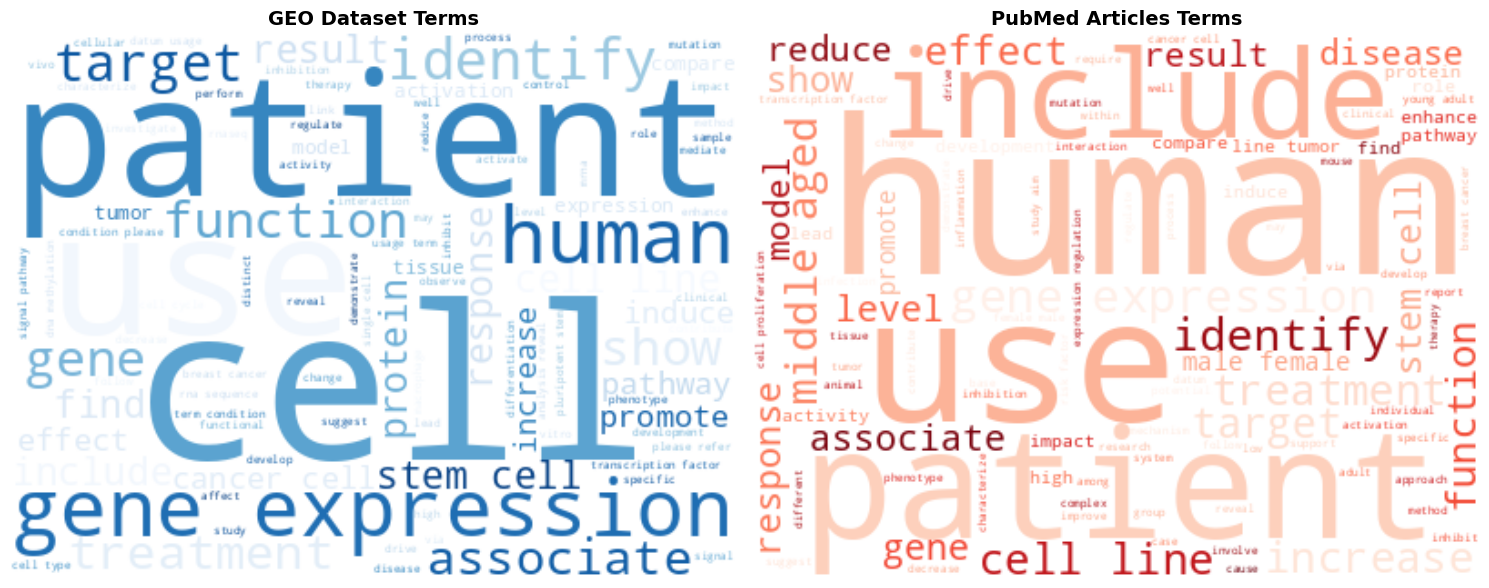

In [ ]:
# 2. Frequent terms analysis
print("\n2. FREQUENT TERMS ANALYSIS:")
print("\nGEO Dataset:")
geo_freq, geo_top = analyze_frequent_terms(geo_df, top_n = 10)
print("\nPubMed Dataset:")
pubmed_freq, pubmed_top = analyze_frequent_terms(pubmed_df, top_n = 10)

# 3. Create word clouds
create_wordclouds(geo_df, pubmed_df)

## **Vectorization:**



### - **Tf-IDF**
Performing tfidf:

Grid search for best parameter

In [ ]:
def grid_search_tfidf(text_corpus, param_grid, sample_doc_index = 0, top_k = 10):
    best_score = -np.inf
    best_vectorizer = None
    best_matrix = None
    best_params = None

    results = []

    for params in ParameterGrid(param_grid):
        try:
            tfidf = TfidfVectorizer(
                stop_words='english',
                max_features=params['max_features'],
                min_df=params['min_df'],
                max_df=params['max_df'],
                sublinear_tf = True
            )
            tfidf_matrix = tfidf.fit_transform(text_corpus)

            sim = cosine_similarity(tfidf_matrix[sample_doc_index], tfidf_matrix).flatten()
            sim[sample_doc_index] = 0
            avg_score = np.mean(np.sort(sim)[-top_k:])

            results.append({**params, 'avg_similarity': avg_score})

            if avg_score > best_score:
                best_score = avg_score
                best_vectorizer = tfidf
                best_matrix = tfidf_matrix
                best_params = params
        except Exception as e:
            print(f"Skipped params {params} due to error: {e}")
            continue

    print(f"\nBest TF-IDF Params: {best_params}")
    return best_vectorizer, best_params


In [ ]:
# Define grid
param_grid = {
    'max_features': [50000, 100000, 1000000],
    'min_df': [2, 3, 5],  # filter extremely rare words(noise)
    'max_df': [0.8, 0.9]} # filters extremely common words present in 80 to 90%
# Optimize TF-IDF
best_vectorizer, best_params = grid_search_tfidf(entire_text, param_grid)


Best TF-IDF Params: {'max_df': 0.8, 'max_features': 50000, 'min_df': 5}


Analyzing vocab for tfidf

In [ ]:
def analyze_vocabulary(vectorizer, geo_vectors, pubmed_vectors, top_n = 10):
        """
        Analyze the TF-IDF vocabulary for insights
        """

        # Get feature names and their average TF-IDF scores
        feature_names = vectorizer.get_feature_names_out()

        # Calculate average TF-IDF scores across all documents
        geo_mean_scores = np.mean(geo_vectors.toarray(), axis = 0)
        pubmed_mean_scores = np.mean(pubmed_vectors.toarray(), axis = 0)

        # Get top features for each dataset
        geo_top_idx = np.argsort(geo_mean_scores)[::-1][:top_n]
        pubmed_top_idx = np.argsort(pubmed_mean_scores)[::-1][:top_n]

        print(f"\nTop {top_n} TF-IDF features in GEO data:")
        print("-----------------------------------------")
        for idx in geo_top_idx:
            print(f"  {feature_names[idx]}")

        print(f"\nTop {top_n} TF-IDF features in PubMed data:")
        print("-----------------------------------------")
        for idx in pubmed_top_idx:
            print(f"  {feature_names[idx]}")

In [ ]:
geo_text = geo_df.iloc[:, 0].astype(str).tolist()
pubmed_text = pubmed_df.iloc[:, 0].astype(str).tolist()

tfidf_geo = best_vectorizer.transform(geo_text)
tfidf_pubmed = best_vectorizer.transform(pubmed_text)
analyze_vocabulary(best_vectorizer, tfidf_geo, tfidf_pubmed, top_n=10)


Top 10 TF-IDF features in GEO data:
-----------------------------------------
  cell
  gene
  expression
  datum
  usage
  refer
  term
  cancer
  condition
  rna

Top 10 TF-IDF features in PubMed data:
-----------------------------------------
  cell
  human
  study
  female
  aged
  patient
  adult
  male
  disease
  cancer


Function for similarity calculation and recommending top 10 articles


In [ ]:
def cos_similarity(tfidf_geo, tfidf_pubmed, pubmed_data, k = 10):
  similarity_matrix = cosine_similarity(tfidf_geo, tfidf_pubmed)
  top_k_indices = np.argsort(-similarity_matrix, axis=1)[:, :k]
  top_k_pmids = pubmed_data['PMID'].values[top_k_indices]
  return similarity_matrix, top_k_pmids

def print_top_matches(similarity_matrix, geo_df, pubmed_df, k = 10, n_geo = 1):
  """Prints top k most similar PubMed articles for the GEO records"""
  print(f"\n GEO Sample [{n_geo}]")
  print("Title:", geo_df.iloc[n_geo]['Title'])
  print("Summary:", geo_df.iloc[n_geo]['Summary'])

  print("\nTop", k, "Most Similar PubMed Articles:")
  print("---------------------------------------------------")

  sim_scores = similarity_matrix[n_geo]
  top_indices = np.argsort(sim_scores)[::-1][:k]

  for i, idx in enumerate(top_indices):
    pmid = pubmed_df.iloc[idx]['PMID']
    title = pubmed_df.iloc[idx]['Title']
    score = similarity_matrix[n_geo][idx]

    print(f"[{i+1}] PMID: {pmid}")
    # print(f"Similarity Score: {score:.4f}")
    print(f"Title: {title}")

Performing similarity calculation and recommending top 10 articles for TFIDF

In [ ]:
similarity_matrixtfidf, top_k_pmidstfidf = cos_similarity(tfidf_geo, tfidf_pubmed, pubmed_data, k = 10)
print_top_matches(similarity_matrixtfidf, geo_data, pubmed_data, k = 10, n_geo= 0)


 GEO Sample [0]
Title: antibiotic drive gut microbiome perturbation alter immune response rabie vaccine
Summary: gut microbiome play crucial role modulate human immunity previously find antibioticinduce microbiome perturbation affect influenza vaccine response depend preexist immunity level however impact primary response remain unclear employ system biology approach analyze impact antibiotic administration primary secondary immune response rabie vaccine humans antibiotic administration disrupt microbiome reduce gut bacterial load cause longlaste reduction commensal diversity alteration associate reduce rabiesspecific humoral response multiomic profiling reveal antibiotic administration induce enhance proinflammatory signature early vaccination shift balance vaccinespecific thelper 1th1 tfollicularhelper response towards th1 phenotype profound alteration metabolite particularly secondary bile acid blood integrate multiomics dataset generate multiscale multiresponse network reveal key 

In [ ]:
similarity_matrixtfidf.shape

(3511, 5000)

### **Evaluation:**

Preparing data for evaluation. As we have PMID column in geo dataset that matches the PMIDs column of pubmed datasets, we will use it to see if the recommender system recommends it after calculating the similarity and ranking top k

In [ ]:
def evaluate_retrieval(geo_data, pubmed_data, top_k_recommendations, k = 10):
    """
        geo_data: DataFrame with 'PMIDs_list' column (list of PMIDs per row)
        pubmed_data: DataFrame with 'PMID' column
        top_k_recommendations: List of lists of recommended PMIDs
        k: Cutoff for evaluation metrics

    Returns:
        Dictionary of evaluation metrics
    """
    # Preprocess PMIDs
    pubmed_pmids = set(str(pmid).strip() for pmid in pubmed_data['PMID'].tolist())

    # Initialize metrics
    metrics = {
        'MRR@k': [],
        'Recall@1': [],
        'Recall@k': [],
        'Precision@1': [],
        'MAP@k': [],
        'valid_queries': 0
    }

    for pmid_list, recommendations in zip(geo_data['PMIDs_list'], top_k_recommendations):
        # Skip empty or NaN entries
        if not isinstance(pmid_list, list) or len(pmid_list) == 0:
            continue

        # Convert GEO PMIDs and recommendations to strings
        geo_pmids_str = [str(pmid).strip() for pmid in pmid_list]
        recommendations = [str(pmid).strip() for pmid in recommendations[:k]]

        # Convert to strings and filter for those present in PubMed
        valid_gt = [pmid for pmid in geo_pmids_str if pmid in pubmed_pmids]

        # Skip if no valid ground truth PMIDs
        if not valid_gt:
            continue

        metrics['valid_queries'] += 1
        # Calculate metrics

        # MRR@k
        rr = next((1/(i+1) for i, pmid in enumerate(recommendations) if pmid in valid_gt), 0)
        metrics['MRR@k'].append(rr)

        # Recall@k and Precision@k
        metrics['Recall@k'].append(len(set(recommendations) & set(valid_gt)) / len(valid_gt))


        # MAP@k
        precisions = []
        relevant_count = 0
        for i, pmid in enumerate(recommendations, 1):
            if pmid in valid_gt:
                relevant_count += 1
                precisions.append(relevant_count / i)
        metrics['MAP@k'].append(sum(precisions)/len(valid_gt) if precisions else 0)

    # Calculate averages
    results = {key: np.mean(values) if values else 0
               for key, values in metrics.items() if key != 'valid_queries'}
    results['valid_queries'] = metrics['valid_queries']

    return results

1. Mean Reciprocal Rank
tells us how high the first correct match appears in the top recommendation,
- value 1 means correct maatch is ranked 1st.
- value of 0 means no correct match found in top-k

2. Recall@k
Tells us whether the recommendation is a correct match with ground truth.

3. MAP@k
- Averages the precision at each point where a relevant item appears.
- Rewards systems that rank relevant items earlier in the list.





In [ ]:
results = evaluate_retrieval(geo_data, pubmed_data, top_k_pmidstfidf, k=10)

print('Evaluation for TD-IDF:')
print('------------------------------------')
print(f"Valid queries evaluated: {results['valid_queries']}")
print(f"MRR@10: {results['MRR@k']:.4f}")
print(f"Recall@10: {results['Recall@k']:.4f}")
print(f"MAP@10: {results['MAP@k']:.4f}")

Evaluation for TD-IDF:
------------------------------------
Valid queries evaluated: 3511
MRR@10: 0.8422
Recall@10: 0.8718
MAP@10: 0.8414



### - Weighted Tf-IDF: (Adding more words of mesh term and title to increase its importance)

#### This increases the term frequency of the words we want to give more importance to, here we used the mesh_terms column.

In [ ]:
def prepare_weighted_pubmed(row):
    weights = {'title': 0.2, 'abstract': 0.1, 'mesh': 0.3}

    title = str(row['Title']) if pd.notnull(row['Title']) else ''
    abstract = str(row['Abstract']) if pd.notnull(row['Abstract']) else ''
    mesh = str(row['MeSH_Terms']) if pd.notnull(row['MeSH_Terms']) else ''

    # Rebalance if MeSH missing
    if not mesh.strip():
        weights = {'title': 0.2, 'abstract': 0.1, 'mesh': 0}

    return (
        (title + " ") * round(weights['title'] * 10) +
        (abstract + " ") * round(weights['abstract'] * 10) +
        (mesh + " ") * round(weights['mesh'] * 10)
    )

def prepare_weighted_geo(row):
    weights = {'title': 0.2, 'summary': 0.1}

    title = str(row['Title']) if pd.notnull(row['Title']) else ''
    summary = str(row['Summary']) if pd.notnull(row['Summary']) else ''

    return (
        (title + " ") * round(weights['title'] * 10) +
        (summary + " ") * round(weights['summary'] * 10)
    )

In [ ]:
# Prepare weighted texts
pubmed_2 = pubmed_data.copy()
pubmed_2['weighted_text'] = pubmed_2.apply(prepare_weighted_pubmed, axis = 1)

geo_2 = geo_data.copy()
geo_2['weighted_text'] = geo_2.apply(prepare_weighted_geo, axis = 1)


# Fit vectorizer on ALL weighted text for consistent vocabulary
all_texts = geo_2['weighted_text'].tolist() + pubmed_2['weighted_text'].tolist()

vectorizer = TfidfVectorizer(max_df = 0.8, max_features =  100000, min_df =  3)
vectorizer.fit(all_texts)


# Transform separately
geo_weighttfidf = vectorizer.transform(geo_2['weighted_text'])
pubmed_weighttfidf = vectorizer.transform(pubmed_2['weighted_text'])
analyze_vocabulary(vectorizer, geo_weighttfidf, pubmed_weighttfidf, top_n=10)


Top 10 TF-IDF features in GEO data:
-----------------------------------------
  cell
  gene
  cancer
  expression
  rnaseq
  snrnaseq
  please
  rna
  datum
  patient

Top 10 TF-IDF features in PubMed data:
-----------------------------------------
  cell
  human
  aged
  female
  adult
  male
  protein
  tumor
  study
  neoplasm


Similarity calc and top 10 recommendation for weighted tfidf

In [ ]:
similarity_matrix_weighted, top_k_pmids_weighted = cos_similarity(geo_weighttfidf, pubmed_weighttfidf, pubmed_data, k=10)
print_top_matches(similarity_matrix_weighted, geo_data, pubmed_data, k = 10, n_geo= 0)


 GEO Sample [0]
Title: antibiotic drive gut microbiome perturbation alter immune response rabie vaccine
Summary: gut microbiome play crucial role modulate human immunity previously find antibioticinduce microbiome perturbation affect influenza vaccine response depend preexist immunity level however impact primary response remain unclear employ system biology approach analyze impact antibiotic administration primary secondary immune response rabie vaccine humans antibiotic administration disrupt microbiome reduce gut bacterial load cause longlaste reduction commensal diversity alteration associate reduce rabiesspecific humoral response multiomic profiling reveal antibiotic administration induce enhance proinflammatory signature early vaccination shift balance vaccinespecific thelper 1th1 tfollicularhelper response towards th1 phenotype profound alteration metabolite particularly secondary bile acid blood integrate multiomics dataset generate multiscale multiresponse network reveal key 

In [ ]:
# Evaluate
results_weighted = evaluate_retrieval(geo_data, pubmed_data, top_k_pmids_weighted, k = 10)

print('Evaluation for weighted TF-IDF:')
print('------------------------------------')
print(f"Valid queries evaluated: {results_weighted['valid_queries']}")
print(f"MRR@10: {results_weighted['MRR@k']:.4f}")
print(f"Recall@10: {results_weighted['Recall@k']:.4f}")
print(f"MAP@10: {results_weighted['MAP@k']:.4f}")

Evaluation for weighted TF-IDF:
------------------------------------
Valid queries evaluated: 3511
MRR@10: 0.8357
Recall@10: 0.8710
MAP@10: 0.8346


--- Another way of performing weighted tf idf-- Feature weighting

In [ ]:
combined_title = geo_data['Title'].fillna('').tolist() + pubmed_data['Title'].fillna('').tolist()
combined_abstract = geo_data['Summary'].fillna('').tolist() + pubmed_data['Abstract'].fillna('').tolist()
combined_mesh = pubmed_data['MeSH_Terms'].fillna('').tolist()  # Only in PubMed

In [ ]:
vectorizer_title = TfidfVectorizer(stop_words='english', max_features = 1000000)
vectorizer_title.fit(combined_title)

vectorizer_abstract = TfidfVectorizer(stop_words='english', max_features = 100000)
vectorizer_abstract.fit(combined_abstract)

vectorizer_mesh = TfidfVectorizer(stop_words='english', max_features = 100000)
vectorizer_mesh.fit(combined_mesh)

TfidfVectorizer(max_features=100000, stop_words='english')

In [ ]:
# For GEO
geo_title_vec = vectorizer_title.transform(geo_data['Title'].fillna(''))
geo_abstract_vec = vectorizer_abstract.transform(geo_data['Summary'].fillna(''))

# For PubMed
pubmed_title_vec = vectorizer_title.transform(pubmed_data['Title'].fillna(''))
pubmed_abstract_vec = vectorizer_abstract.transform(pubmed_data['Abstract'].fillna(''))
pubmed_mesh_vec = vectorizer_mesh.transform(pubmed_data['MeSH_Terms'].fillna(''))


In [ ]:
title_weight = 0.3
abstract_weight = 0.3
mesh_weight = 0.4

# GEO only has title + summary (as abstract)
geo_weighted2 = hstack([
    geo_title_vec * title_weight,
    geo_abstract_vec * abstract_weight,
    # No mesh for GEO → fill with zeros
    np.zeros((geo_title_vec.shape[0], pubmed_mesh_vec.shape[1]))
])

# PubMed has all 3
pubmed_weighted2 = hstack([
    pubmed_title_vec * title_weight,
    pubmed_abstract_vec * abstract_weight,
    pubmed_mesh_vec * mesh_weight
])

In [ ]:
similarity_matrix_weighted2, top_k_pmids_weighted2 = cos_similarity(geo_weighted2, pubmed_weighted2, pubmed_data, k = 10)
print_top_matches(similarity_matrix_weighted2, geo_data, pubmed_data, k = 10, n_geo= 0)


 GEO Sample [0]
Title: antibiotic drive gut microbiome perturbation alter immune response rabie vaccine
Summary: gut microbiome play crucial role modulate human immunity previously find antibioticinduce microbiome perturbation affect influenza vaccine response depend preexist immunity level however impact primary response remain unclear employ system biology approach analyze impact antibiotic administration primary secondary immune response rabie vaccine humans antibiotic administration disrupt microbiome reduce gut bacterial load cause longlaste reduction commensal diversity alteration associate reduce rabiesspecific humoral response multiomic profiling reveal antibiotic administration induce enhance proinflammatory signature early vaccination shift balance vaccinespecific thelper 1th1 tfollicularhelper response towards th1 phenotype profound alteration metabolite particularly secondary bile acid blood integrate multiomics dataset generate multiscale multiresponse network reveal key 

In [ ]:
len(similarity_matrix_weighted2)

3511

In [ ]:
results_weighted = evaluate_retrieval(geo_data, pubmed_data, top_k_pmids_weighted2, k = 10)

print('Evaluation for TD-IDF:')
print('------------------------------------')
print(f"Valid queries evaluated: {results_weighted['valid_queries']}")
print(f"MRR@10: {results_weighted['MRR@k']:.4f}")
print(f"Recall@10: {results_weighted['Recall@k']:.4f}")
print(f"MAP@10: {results_weighted['MAP@k']:.4f}")

Evaluation for TD-IDF:
------------------------------------
Valid queries evaluated: 3511
MRR@10: 0.8305
Recall@10: 0.8621
MAP@10: 0.8291


### Word2Vec

Pre processing word2vec converting to tokens

In [ ]:
def preprocess_word2vec_text(text):
    tokens = text.split()
    return tokens
geo_tokens = geo_df[0].apply(preprocess_word2vec_text)
pubmed_tokens = pubmed_df[0].apply(preprocess_word2vec_text)


In [ ]:
geo_tokens

,0
0,"[antibiotic, drive, gut, microbiome, perturbat..."
1,"[gene, knockout, screen, identify, gene, invol..."
2,"[gene, expression, profile, embryonic, stem, c..."
3,"[gene, expression, profile, embryonic, stem, c..."
4,"[transcriptional, response, prevnar13, vaccina..."
...,...
3506,"[id1, id3, function, modulation, tumor, immune..."
3507,"[epigenetic, change, cerebrospinal, fluid, blo..."
3508,"[transcriptomic, profile, effect, inducible, k..."
3509,"[efficient, derivation, functional, astrocyte,..."


Corpus is all the words of geo and pubmed in lists
- vector_size sets the dimensionality of the word vectors.Larger values capture more information but take more memory and time.
- window = maximum distance between current word and predicted word, window 5 means model looks at 5 words to left and right to understand context.
- min_count = ignores words with total frequency less than 3 in corpus(removes noise or very rare words that might not be useful.)
- workers = uses 4 threasd to train model in parallel, speeds training.
- sg = 1 (
  0: means Continuous bag of words model(faster, better for frequent words
  1: Skip gram model(good for smaller data, learns rare words better)




In [ ]:
corpus = geo_tokens.tolist() + pubmed_tokens.tolist()
corpus
model = Word2Vec(corpus, vector_size = 200, window = 15, min_count = 5, workers = 4, sg = 1)

In [ ]:
print(len(corpus))

8511


In [ ]:
def document_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis = 0)

geo_vectors = geo_tokens.apply(lambda tokens: document_vector(tokens, model))
pubmed_vectors = pubmed_tokens.apply(lambda tokens: document_vector(tokens, model))

In [ ]:
# converting to numpy matrix
geo_matrix = np.vstack(geo_vectors.values)
pubmed_matrix = np.vstack(pubmed_vectors.values)


similarity calc and top 10 recommendadtion for word2vec

In [ ]:
similarity_matrix_word2vec, top_k_pmids_word2vec = cos_similarity(geo_matrix, pubmed_matrix, pubmed_data, k = 10)
print_top_matches(similarity_matrix_word2vec, geo_data, pubmed_data, k = 10, n_geo= 0)


 GEO Sample [0]
Title: antibiotic drive gut microbiome perturbation alter immune response rabie vaccine
Summary: gut microbiome play crucial role modulate human immunity previously find antibioticinduce microbiome perturbation affect influenza vaccine response depend preexist immunity level however impact primary response remain unclear employ system biology approach analyze impact antibiotic administration primary secondary immune response rabie vaccine humans antibiotic administration disrupt microbiome reduce gut bacterial load cause longlaste reduction commensal diversity alteration associate reduce rabiesspecific humoral response multiomic profiling reveal antibiotic administration induce enhance proinflammatory signature early vaccination shift balance vaccinespecific thelper 1th1 tfollicularhelper response towards th1 phenotype profound alteration metabolite particularly secondary bile acid blood integrate multiomics dataset generate multiscale multiresponse network reveal key 

In [ ]:
similarity_matrix_word2vec.shape

(3511, 5000)

In [ ]:
results_word2vec = evaluate_retrieval(geo_data, pubmed_data, top_k_pmids_word2vec, k = 10)
print('Evaluation for word2vec:')
print('------------------------------------')
print(f"Valid queries evaluated: {results_word2vec['valid_queries']}")
print(f"MRR@10: {results_word2vec['MRR@k']:.4f}")
print(f"Recall@10: {results_word2vec['Recall@k']:.4f}")
print(f"MAP@10: {results_word2vec['MAP@k']:.4f}")

Evaluation for word2vec:
------------------------------------
Valid queries evaluated: 3511
MRR@10: 0.7543
Recall@10: 0.8095
MAP@10: 0.7528


### BioWord2vec

BioWordVec is a biomedical pre trained work embedding trained on (BioWordVec file is a 200 dimensional vector trained on) PubMed+ MIMIC-III.
--it is a 13 gb .bin data when not zipped(included the zip file names BioWordVec_PubMed_MIMICIII_d200.vec.bin in the file, so if not present please run the code below--

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin

--2025-06-11 15:21:37--  https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451441787 (13G) [application/octet-stream]
Saving to: ‘BioWordVec_PubMed_MIMICIII_d200.vec.bin’

BioWordVec_PubMed_M 100%[===================>]  12.53G  14.6MB/s    in 22m 55s 

2025-06-11 15:44:33 (9.33 MB/s) - ‘BioWordVec_PubMed_MIMICIII_d200.vec.bin’ saved [13451441787/13451441787]



fitting pretrained bioword2vec

In [ ]:
biowordvec_model = KeyedVectors.load_word2vec_format("BioWordVec_PubMed_MIMICIII_d200.vec.bin", binary = True, limit = 1000000) # loading top 1000000 most frequent words,

In [ ]:
def document_vector_biowordvec(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis = 0)

Similarity calc and top 10 recommendation for bioword2vec

In [ ]:
geo_vectors_bio = geo_tokens.apply(lambda tokens: document_vector_biowordvec(tokens, biowordvec_model))
pubmed_vectors_bio = pubmed_tokens.apply(lambda tokens: document_vector_biowordvec(tokens, biowordvec_model))

# Convert to matrices
geo_matrix_bio = np.vstack(geo_vectors_bio.values)
pubmed_matrix_bio = np.vstack(pubmed_vectors_bio.values)

# Calculate similarity
similarity_matrix_bio, top_k_pmids_bio = cos_similarity(geo_matrix_bio, pubmed_matrix_bio, pubmed_data, k = 10)
print_top_matches(similarity_matrix_bio, geo_data, pubmed_data, k = 10, n_geo= 0)


 GEO Sample [0]
Title: antibiotic drive gut microbiome perturbation alter immune response rabie vaccine
Summary: gut microbiome play crucial role modulate human immunity previously find antibioticinduce microbiome perturbation affect influenza vaccine response depend preexist immunity level however impact primary response remain unclear employ system biology approach analyze impact antibiotic administration primary secondary immune response rabie vaccine humans antibiotic administration disrupt microbiome reduce gut bacterial load cause longlaste reduction commensal diversity alteration associate reduce rabiesspecific humoral response multiomic profiling reveal antibiotic administration induce enhance proinflammatory signature early vaccination shift balance vaccinespecific thelper 1th1 tfollicularhelper response towards th1 phenotype profound alteration metabolite particularly secondary bile acid blood integrate multiomics dataset generate multiscale multiresponse network reveal key 

In [ ]:
# Evaluate
results_biowordvec = evaluate_retrieval(geo_data, pubmed_data, top_k_pmids_bio, k = 10)
print('BioWordVec Results:')
print('------------------------------------')
print(f"Valid queries evaluated: {results_biowordvec['valid_queries']}")
print(f"MRR@10: {results_biowordvec['MRR@k']:.4f}")
print(f"Recall@10: {results_biowordvec['Recall@k']:.4f}")
print(f"MAP@10: {results_biowordvec['MAP@k']:.4f}")

BioWordVec Results:
------------------------------------
Valid queries evaluated: 3511
MRR@10: 0.7212
Recall@10: 0.7805
MAP@10: 0.7192


## Trial -------------------------------
Lets try to combine word2vec and tfidf by using the similarity score and putting weights on them



In [ ]:
# Trying to see the min and max of the similarity score of the two matrices to ensure its comparable\
max_val_word = np.max(similarity_matrix_word2vec)
min_val_word = np.min(similarity_matrix_word2vec)
print("Max similarity of word2vec:", max_val_word)
print("Min similarity of word2vec:", min_val_word)

max_val_tfidf = np.max(similarity_matrixtfidf)
min_val_tfidf = np.min(similarity_matrixtfidf)
print("Max similarity of tfidf:", max_val_tfidf)
print("Min similarity of tfidf:", min_val_tfidf)

Max similarity of word2vec: 1.0000004
Min similarity of word2vec: 0.16585168
Max similarity of tfidf: 1.0000000000000002
Min similarity of tfidf: 0.0


Normalizing into the same scale first--- even though same scale without normalizing gave worse result


In [ ]:
def rowwise_zscore(matrix):
    return np.nan_to_num(zscore(matrix, axis=1))

z_word2vec = rowwise_zscore(similarity_matrix_word2vec)
z_tfidf = rowwise_zscore(similarity_matrixtfidf)


In [ ]:
combined_score = 0.5 * z_tfidf + 0.5 * z_word2vec

top_k = 10
top_k_indices_combo = combined_score.argsort(axis=1)[:, -top_k:][:, ::-1]
top_k_pmidsforcombo = np.take(pubmed_data['PMID'].values, top_k_indices_combo)
top_k_pmidsforcombo[0:2]


array([['40252648', '40101713', '40406109', '40175554', '40169665',
        '40414643', '40294012', '40444030', '39749328', '40423338'],
       ['40377017', '39495628', '36711601', '32051547', '38039131',
        '39680368', '40424148', '39578497', '40108406', '39891176']],
      dtype=object)

In [ ]:
results_combined = evaluate_retrieval(geo_data, pubmed_data, top_k_pmidsforcombo , k = 10)
print('Evaluation for word2vec:')
print('------------------------------------')
print(f"Valid queries evaluated: {results_combined['valid_queries']}")
print(f"MRR@10: {results_combined['MRR@k']:.4f}")
print(f"Recall@10: {results_combined['Recall@k']:.4f}")
print(f"MAP@10: {results_combined['MAP@k']:.4f}")

Evaluation for word2vec:
------------------------------------
Valid queries evaluated: 3511
MRR@10: 0.8431
Recall@10: 0.8731
MAP@10: 0.8423


Experimented with diff weight for gave a similar score as what tfidf gave